In [125]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Exercise Classification

 - Import aps_failure_training_set.csv file and aps_failure_test_set.csv

 - Using training dataset, train a NN to predict the class. It indicates if there is failure in the trucks.

 - When using common accuracy metrics we know if our model is good, but is it good enough? We will define a new specific metric for this problem: **Total cost**. For each truck we say it fails, the company sends a mechanic to review the truck, which supposes a cost of 10. On the other hand, if we say there is not failure when they actually are, the truck breakdowns, which supposes a cost of 500. In summary, False positives cost 10, and False negatives cost 500.

 - Train several NN and keep the one with less total costs. Your goal is to achieve a Total cost lower than 1

 - The evaluation phase (Total cost calculation) must be done using the test dataset (aps_failure_test_set.csv)

 - Below some pieces of code that can help you complete the exercise, specially the last one, where the definition of the Total cost is

In [126]:
import plotly
import plotly.graph_objs as go

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import numpy as np
import pandas as pd
from matplotlib import pyplot

from tabulate import tabulate
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix # for model evaluation metrics
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from keras.optimizers import Adam
from tensorflow.keras.metrics import Recall
from tensorflow.keras.callbacks import EarlyStopping

In [127]:
data1 = pd.read_csv('/content/drive/MyDrive/Ironhack/25octubre/aps_failure_training_set.csv')
data1.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,neg,33058,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,neg,41040,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,neg,12,0.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,neg,60874,NaN,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0


In [128]:
data2 = pd.read_csv('/content/drive/MyDrive/Ironhack/25octubre/aps_failure_test_set.csv')
data2.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,60,0.0,20.0,12.0,0.0,0.0,0.0,0.0,0.0,...,1098.0,138.0,412.0,654.0,78.0,88.0,0.0,0.0,0.0,0.0
1,neg,82,0.0,68.0,40.0,0.0,0.0,0.0,0.0,0.0,...,1068.0,276.0,1620.0,116.0,86.0,462.0,0.0,0.0,0.0,0.0
2,neg,66002,2.0,212.0,112.0,0.0,0.0,0.0,0.0,0.0,...,495076.0,380368.0,440134.0,269556.0,1315022.0,153680.0,516.0,0.0,0.0,0.0
3,neg,59816,NaN,1010.0,936.0,0.0,0.0,0.0,0.0,0.0,...,540820.0,243270.0,483302.0,485332.0,431376.0,210074.0,281662.0,3232.0,0.0,0.0
4,neg,1814,NaN,156.0,140.0,0.0,0.0,0.0,0.0,0.0,...,7646.0,4144.0,18466.0,49782.0,3176.0,482.0,76.0,0.0,0.0,0.0


In [129]:
# Código para pintar gráfico con el porcentaje de valores perdidos por variable
NULL_RATIO_TRHESHOLD = 0 # Set the null ratio threshold required


null_ratios = (data1.isnull().sum() / data1.shape[0])
null_ratios_over_threshold = null_ratios[null_ratios > NULL_RATIO_TRHESHOLD].sort_values(ascending=False)

data_go = [
    go.Bar(
        x=null_ratios_over_threshold.index,
        y=null_ratios_over_threshold
    )
]

fig = go.Figure(data=data_go, layout={
    "title": "Null Ratio for Features with Null Ratio Exceeding {}".format(NULL_RATIO_TRHESHOLD)
})

plotly.offline.iplot(fig)

In [130]:
null_ratios_over_threshold = null_ratios[null_ratios > NULL_RATIO_TRHESHOLD].sort_values(ascending=False)
nan_columns = list(null_ratios_over_threshold[null_ratios_over_threshold>0.1].index)

In [131]:
data1.drop(nan_columns, axis = 1, inplace = True)
# eliminamos las variables con demaisados missing, y corregimos por la media los que solo tienen hasta un 10% de valores perdidos
# 1. Manejo de columnas no numéricas con valores faltantes
non_numeric_columns = data1.select_dtypes(exclude=['number']).columns
for column in non_numeric_columns:
    data1[column].fillna('desconocido', inplace=True)  # Reemplaza los valores faltantes con "desconocido" u otra etiqueta apropiada

# 2. Rellenar columnas numéricas con la media
numeric_columns = data1.select_dtypes(include=['number']).columns
for column in numeric_columns:
    data1[column].fillna(data1[column].mean(), inplace=True)

In [132]:
X_train, X_test, y_train, y_test = train_test_split(data1.drop('class',axis=1),
                                                    data1['class'], train_size = 0.8, random_state = 0)
X_train.head(3)

,aa_000,ac_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
5778,60660,266.0,0.0,0.0,0.0,0.0,0.0,0.0,3236.0,499876.0,...,273744.0,145088.0,311782.0,371428.0,371870.0,381522.0,700624.0,9062.0,0.0,0.0
5287,3412,86.0,0.0,0.0,0.0,0.0,0.0,0.0,122.0,18492.0,...,9260.0,4462.0,11122.0,9132.0,11944.0,15364.0,70760.0,1712.0,0.0,0.0
57167,29664,0.0,0.0,0.0,0.0,0.0,0.0,0.0,612.0,316230.0,...,409912.0,222004.0,393608.0,182968.0,97552.0,45586.0,30968.0,268.0,0.0,0.0


In [133]:
# Para equilibrar la variable respuesta
ros = RandomOverSampler(random_state=42)
X_train, y_train= ros.fit_resample(X_train, y_train)

In [134]:
y_train = pd.get_dummies(y_train).drop('neg',axis = 1)
y_test = pd.get_dummies(y_test).drop('neg',axis = 1)

In [135]:
scaler = StandardScaler()
sc = scaler.fit(X_train)
train_sc = sc.transform(X_train)
X_train_sc = pd.DataFrame(train_sc)
X_train_sc.columns = X_train.columns

test_sc = sc.transform(X_test)
X_test_sc = pd.DataFrame(test_sc)
X_test_sc.columns = X_test.columns

print(X_train_sc.shape)
print(X_test_sc.shape)

(94368, 142)
(12000, 142)


In [136]:
X_train_sc.columns

Index(['aa_000', 'ac_000', 'ae_000', 'af_000', 'ag_000', 'ag_001', 'ag_002',
       'ag_003', 'ag_004', 'ag_005',
       ...
       'ee_002', 'ee_003', 'ee_004', 'ee_005', 'ee_006', 'ee_007', 'ee_008',
       'ee_009', 'ef_000', 'eg_000'],
      dtype='object', length=142)

In [137]:
MLP_Clas = Sequential()

MLP_Clas.add(Dense(10, input_shape=(142,), activation='relu'))
MLP_Clas.add(BatchNormalization())

MLP_Clas.add(Dense(32, activation='relu'))
MLP_Clas.add(BatchNormalization())
MLP_Clas.add(Dropout(0.2))

MLP_Clas.add(Dense(32, activation='relu'))
MLP_Clas.add(BatchNormalization())

MLP_Clas.add(Dense(1, activation='sigmoid'))

In [138]:
# Learning rate and optimizer
learning_rate = 0.1
optimizer = Adam(learning_rate=learning_rate)

# compile the keras model
MLP_Clas.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy']) # metrics=['accuracy'], Recall()

In [139]:
history_clas = MLP_Clas.fit(X_train_sc, y_train, validation_data=(X_test_sc, y_test), epochs=10, batch_size=30)

Epoch 1/10
3146/3146 [==============================] - 23s 6ms/step - loss: 0.1518 - accuracy: 0.9522 - val_loss: 0.1093 - val_accuracy: 0.9661
Epoch 2/10
3146/3146 [==============================] - 24s 8ms/step - loss: 0.1131 - accuracy: 0.9662 - val_loss: 0.0940 - val_accuracy: 0.9713
Epoch 3/10
3146/3146 [==============================] - 21s 7ms/step - loss: 0.0975 - accuracy: 0.9727 - val_loss: 0.1109 - val_accuracy: 0.9719
Epoch 4/10
3146/3146 [==============================] - 21s 7ms/step - loss: 0.0868 - accuracy: 0.9769 - val_loss: 0.0823 - val_accuracy: 0.9797
Epoch 5/10
3146/3146 [==============================] - 20s 6ms/step - loss: 0.0796 - accuracy: 0.9791 - val_loss: 0.0871 - val_accuracy: 0.9789
Epoch 6/10
3146/3146 [==============================] - 21s 7ms/step - loss: 0.0755 - accuracy: 0.9801 - val_loss: 0.0807 - val_accuracy: 0.9789
Epoch 7/10
3146/3146 [==============================] - 20s 6ms/step - loss: 0.0712 - accuracy: 0.9819 - val_loss: 0.0692 - val_ac

In [140]:
#evaluate the keras model
_, accuracy_tr = MLP_Clas.evaluate(X_train_sc, y_train)
_, accuracy_ts= MLP_Clas.evaluate(X_test_sc, y_test)
print('Accuracy train: %.2f' % (accuracy_tr*100))
print('Accuracy test: %.2f' % (accuracy_ts*100))

375/375 [==============================] - 1s 3ms/step - loss: 0.0615 - accuracy: 0.9837
Accuracy train: 98.13
Accuracy test: 98.37


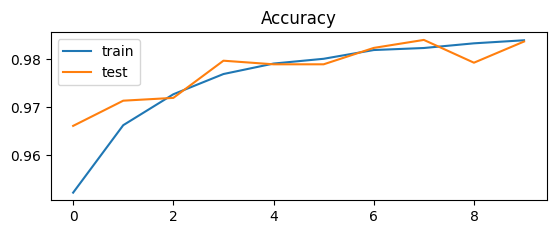

In [141]:
pyplot.subplot(211)
pyplot.title('Accuracy')
pyplot.plot(history_clas.history['accuracy'], label='train')
pyplot.plot(history_clas.history['val_accuracy'], label='test')
pyplot.legend()

In [142]:
# código para representar la matriz de confusión a partir de la predicción de la red entrenada
# En la última línea tenemos cómo calcular el Total Cost
predictions = MLP_Clas.predict(X_test_sc, verbose = 0).round(0)
conf_mat = confusion_matrix(y_test, predictions)
print(tabulate(conf_mat,headers = ['pred breackdown No','pred breackdown Yes'], showindex = ['real breackdown No','real breackdown Yes'],
               tablefmt = 'fancy_grid'))

print(classification_report(y_test, predictions))

print("Total cost: {}".format((conf_mat[1][0] * 500 + conf_mat[0][1] * 10) / X_test_sc.shape[0]))

╒═════════════════════╤══════════════════════╤═══════════════════════╕
│                     │   pred breackdown No │   pred breackdown Yes │
╞═════════════════════╪══════════════════════╪═══════════════════════╡
│ real breackdown No  │                11645 │                   171 │
├─────────────────────┼──────────────────────┼───────────────────────┤
│ real breackdown Yes │                   25 │                   159 │
╘═════════════════════╧══════════════════════╧═══════════════════════╛
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     11816
           1       0.48      0.86      0.62       184

    accuracy                           0.98     12000
   macro avg       0.74      0.92      0.81     12000
weighted avg       0.99      0.98      0.99     12000

Total cost: 1.1841666666666666


## Exercise Regression

 - Import medical_score_train.csv and medical_score_test.csv

 - Using training dataset, train a NN for medical score prediction

 - Your goal is to achieve a MAE lower than 8

In [143]:
from tabulate import tabulate
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2, l1_l2

In [144]:
medicaltrain= pd.read_csv('/content/drive/MyDrive/Ironhack/25octubre/medical_score_train.csv', sep=';')
medicaltrain.drop('Id', axis = 1, inplace = True)
medicaltrain.head()

,score,V3,V4,V5,V6,V7,V8,V9,V10,V11,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29
0,34.130,0.00243,0.000018,0.00108,0.00124,0.00323,0.01147,0.105,0.00625,0.00658,...,-0.824511,-1.217875,-0.432389,-1.455320,-0.280675,0.681113,0.375320,0.764563,-0.237859,-0.282198
1,19.000,0.00280,0.000021,0.00087,0.00128,0.00260,0.01575,0.137,0.00812,0.00868,...,0.080466,-0.812559,1.512731,0.070331,2.368754,-0.256309,1.315997,0.093631,-0.389538,1.396095
2,43.104,0.00412,0.000028,0.00162,0.00213,0.00487,0.02644,0.242,0.01150,0.01423,...,-0.060555,-0.027766,-0.123652,0.820478,1.054439,1.922146,-1.262435,2.017997,0.687229,-0.935456
3,38.814,0.00781,0.000043,0.00451,0.00399,0.01353,0.02975,0.261,0.01650,0.01610,...,-0.153332,-1.298289,1.410486,1.950012,0.613255,0.492419,0.124454,0.891332,0.401179,0.383195
4,41.034,0.00488,0.000026,0.00265,0.00251,0.00794,0.04983,0.448,0.02688,0.02876,...,-0.985639,-0.469064,-2.579920,0.173884,-0.330941,0.089597,0.617369,-0.183967,0.408726,1.607871


In [145]:
medicaltest= pd.read_csv('/content/drive/MyDrive/Ironhack/25octubre/medical_score_test.csv')
medicaltest.head()

,Id,V3,V4,V5,V6,V7,V8,V9,V10,V11,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29
0,1178,0.00465,0.000021,0.00253,0.00254,0.00760,0.01743,0.184,0.00858,0.00974,...,-0.622937,-0.345015,-0.172781,1.632996,-0.819828,1.026481,-1.395062,1.065962,-1.854161,0.424490
1,4954,0.03805,0.000184,0.01723,0.02981,0.05170,0.15431,1.450,0.07356,0.13302,...,-0.563150,-0.403509,-1.149322,0.152665,-0.053284,-0.287827,-0.119217,0.612956,-0.731272,-0.608852
2,1269,0.01094,0.000123,0.00429,0.00502,0.01288,0.04010,0.368,0.01749,0.02065,...,0.077701,-0.061947,0.581850,-0.059723,0.226147,1.613662,0.114775,0.170831,0.159562,-0.571270
3,5269,0.00414,0.000022,0.00183,0.00233,0.00550,0.03073,0.272,0.01636,0.02040,...,-0.106470,0.923359,-1.290854,0.959982,0.232197,-0.669471,-0.049756,-0.110285,0.437221,-1.399420
4,143,0.00688,0.000041,0.00390,0.00307,0.01171,0.04896,0.419,0.03117,0.02345,...,-0.216855,0.516351,1.194716,-0.451112,-0.063620,-1.356854,-0.093523,0.219119,0.943376,0.146435


In [146]:
X_train, X_test, y_train, y_test = train_test_split(medicaltrain.iloc[:,1:],
                                                    medicaltrain.iloc[:,0:1].astype(int), train_size = 0.8, random_state = 0)
X_train.head(3)

,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29
50,0.00354,0.000019,0.00173,0.00201,0.00519,0.01695,0.159,0.00870,0.00984,0.01298,...,-0.342525,0.131178,0.441993,0.705513,-0.585027,-0.451195,0.333431,1.311031,-0.946694,-1.250781
64,0.00523,0.000038,0.00283,0.00264,0.00849,0.02347,0.218,0.00985,0.00950,0.01044,...,-0.336604,-0.812599,-0.332020,0.803171,-0.437687,-0.723893,-1.030945,-1.131642,0.225541,-0.777905
1523,0.00363,0.000024,0.00129,0.00140,0.00387,0.02675,0.225,0.01269,0.01653,0.02105,...,-0.528140,1.351238,-1.205589,-0.789281,0.709038,0.798746,-0.291179,0.370667,2.485730,-0.947459


In [147]:
scaler = StandardScaler()
sc = scaler.fit(X_train)

train_sc = sc.transform(X_train)
X_train_sc = pd.DataFrame(train_sc)
X_train_sc.columns = X_train.columns

test_sc = sc.transform(X_test)
X_test_sc = pd.DataFrame(test_sc)
X_test_sc.columns = X_test.columns

print(X_train_sc.shape)
print(X_test_sc.shape)

(3312, 27)
(829, 27)


In [148]:
MLP_Reg = Sequential()
MLP_Reg.add(Dense(50, input_shape=(27,), activation='sigmoid', kernel_regularizer=l1(0.01)))

MLP_Reg.add(Dense(100, activation='sigmoid', kernel_regularizer=l1(0.01)))
MLP_Reg.add(Dropout(0.2))

MLP_Reg.add(Dense(50, activation='sigmoid', kernel_regularizer=l1(0.01)))
MLP_Reg.add(Dropout(0.2))

MLP_Reg.add(Dense(1, activation='ReLU', kernel_regularizer=l1(0.01)))

In [149]:
# Learning rate and optimizer
learning_rate = 0.01
optimizer = Adam(learning_rate=learning_rate)

# compile the keras model
MLP_Reg.compile(loss='MeanSquaredError', optimizer='sgd', metrics=['MeanAbsoluteError','MeanAbsolutePercentageError'])

In [150]:
history_Reg = MLP_Reg.fit(X_train_sc, y_train, validation_data=(X_test_sc, y_test), epochs=50, batch_size=15)

Epoch 1/50
221/221 [==============================] - 2s 6ms/step - loss: 141.7495 - mean_absolute_error: 9.1286 - mean_absolute_percentage_error: 41.6475 - val_loss: 151.6530 - val_mean_absolute_error: 10.0152 - val_mean_absolute_percentage_error: 52.6974
Epoch 2/50
221/221 [==============================] - 1s 5ms/step - loss: 129.4217 - mean_absolute_error: 8.8007 - mean_absolute_percentage_error: 40.5597 - val_loss: 125.7481 - val_mean_absolute_error: 9.0673 - val_mean_absolute_percentage_error: 44.1252
Epoch 3/50
221/221 [==============================] - 1s 5ms/step - loss: 124.8446 - mean_absolute_error: 8.7031 - mean_absolute_percentage_error: 39.3714 - val_loss: 121.0175 - val_mean_absolute_error: 8.9039 - val_mean_absolute_percentage_error: 42.3268
Epoch 4/50
221/221 [==============================] - 1s 4ms/step - loss: 121.0452 - mean_absolute_error: 8.5595 - mean_absolute_percentage_error: 38.4406 - val_loss: 115.5094 - val_mean_absolute_error: 8.4466 - val_mean_absolute_p

In [152]:
# evaluate the keras model
_, mae_tr, mape_tr = MLP_Reg.evaluate(X_train_sc, y_train)
_, mae_ts, mape_ts = MLP_Reg.evaluate(X_test_sc, y_test)
print('MAE train: %.2f' % mae_tr)
print('MAE test: %.2f' % mae_ts)

26/26 [==============================] - 0s 3ms/step - loss: 108.3021 - mean_absolute_error: 7.5887 - mean_absolute_percentage_error: 32.0730
MAE train: 6.88
MAE test: 7.59


Hemos conseguido que el MAE tenga un valor por debajo de 8.

In [153]:
history_Reg.history.keys()

dict_keys(['loss', 'mean_absolute_error', 'mean_absolute_percentage_error', 'val_loss', 'val_mean_absolute_error', 'val_mean_absolute_percentage_error'])

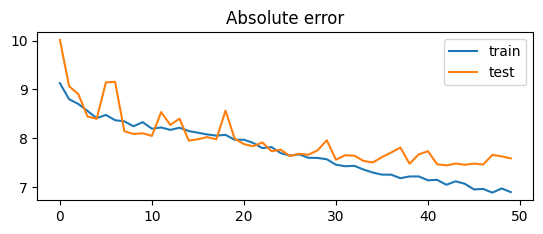

In [154]:
pyplot.subplot(211)
pyplot.title('Absolute error')
pyplot.plot(history_Reg.history['mean_absolute_error'], label='train')
pyplot.plot(history_Reg.history['val_mean_absolute_error'], label='test')
pyplot.legend()